# Sprint 8 | Supervised Learning Project 

<div style="border: 2px solid black; padding: 10px; margin: 10px">

This project will create a model that will accurately detect when a customer will leave the company "Beta Bank". Data on clients' past behavior and termination of contracts with the bank will be used.

We'll attempt to obtain the highest F1 score possible (at least 0.59) and measure the AUC-ROC and compare the two. 

</div>

## Data Preparation for ML

In [6]:
# Importing necessary libraries and packages

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Importing data

data = pd.read_csv('churn.csv')

### Primary Data Processing

#### Columns Formatting

In [12]:
# Removing unnecessary space from beginning and end of column labels
data.columns = data.columns.str.strip()

# Visual validation of column labels
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

#### Null Values

In [16]:
# Checking datatypes in "data" to ensure numeric type

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<div style="border: 2px solid black; padding: 10px; margin: 10px">

We see Null values in our "Tenure" column.
(Original # of non-null values: 9091)<br>

We'll fill these with "0".

</div>

In [18]:
# Replacing Null values with "0"

data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

In [19]:
# Validating no more null values

print(data['Tenure'].isna().sum())

0


#### Checking for Duplicates

In [23]:
# Checking for duplicate values in "data"
# Removing unnecessary columns to detect duplicates after their removal

data_modified = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_modified.duplicated().sum()

0

#### Viewing Data

In [27]:
# Viewing data

data_modified.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<div style="border: 2px solid black; padding: 10px; margin: 10px">

After viewing the data above, we're determing which columns of data we want to include in our features to train our model. Things like "RowNumber", "CustomerId" and "Surname" are irrelevant to determing customer churn for Beta Bank. We will drop those in the code below to refine our "features" dataset.

The columns "Geography" and "Gender" could be valuable in training our model, so we will keep those. They will need to be converted to numerical values. We will do this below using OHE (One-Hot Encoding).

</div>

#### Checking Data Distribution | Age

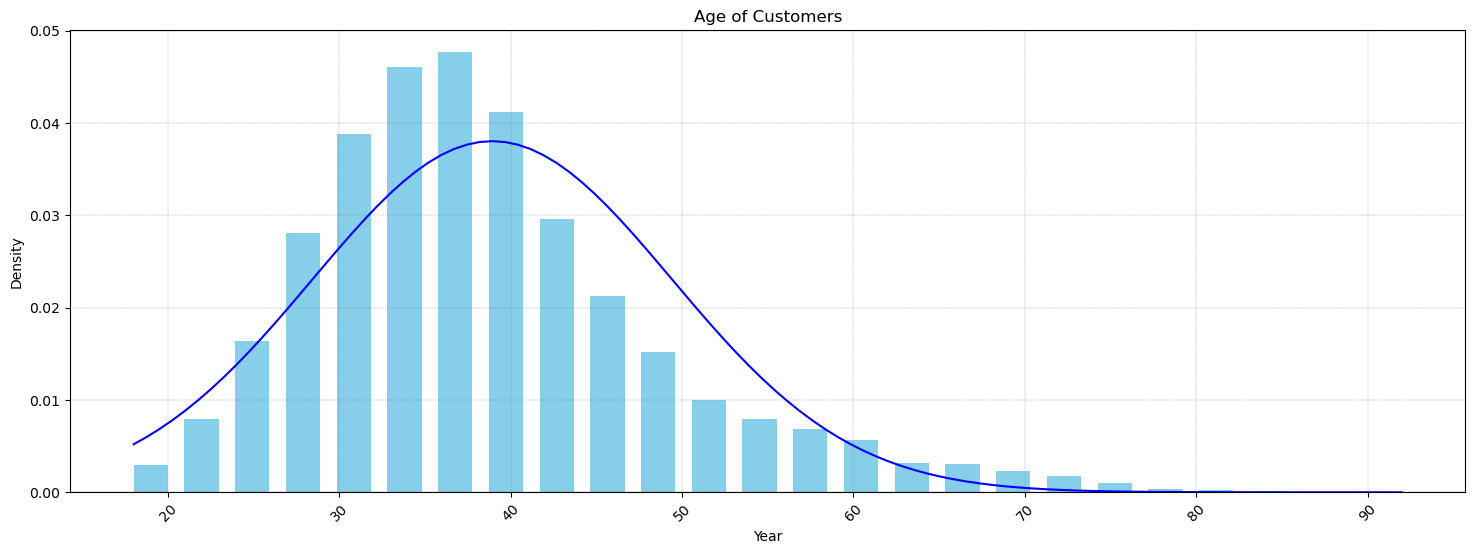

In [32]:
# Histogram showing distribution of "Age" in our data

# Creating histogram
# Setting 'density=True' to normalize the histogram
data_modified.hist(column='Age', 
                   bins=25, 
                   color='skyblue',
                   figsize=(18, 6),
                   width=2,
                   density=True
)

# Setting labels, grid and xtick marks
plt.title('Age of Customers')
plt.xlabel('Year')
plt.ylabel('Density')
plt.grid(True, color='gray', linewidth=0.25, linestyle='--')
plt.xticks(rotation=45, ha='center')

# Generating x-values for distribution curve
x = np.linspace(min(data_modified['Age']), max(data_modified['Age']), 100)

# Plotting distribution curve
plt.plot(x, stats.norm.pdf(x, np.mean(data_modified['Age']), np.std(data_modified['Age'])), 'b', label='Normal Distribution')

# Displaying visualization
plt.show()

In [33]:
# Displaying distribution from describe()

data_modified['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

<div style="border: 2px solid black; padding: 10px; margin: 10px">

As we look at our age data, we're seeing a skew towards the left of the graph implying a higher concentration of young professionals in the customer pool. Seeing as how the mean and the median are very close in proximity, we can determine that although there is a skew to the left, there are some high outliers that are bringing the mean back to the center. We can also tell this by the variance from the 75th percentile to the Max percentile.

</div>

#### Checking Data Distribution | Salary

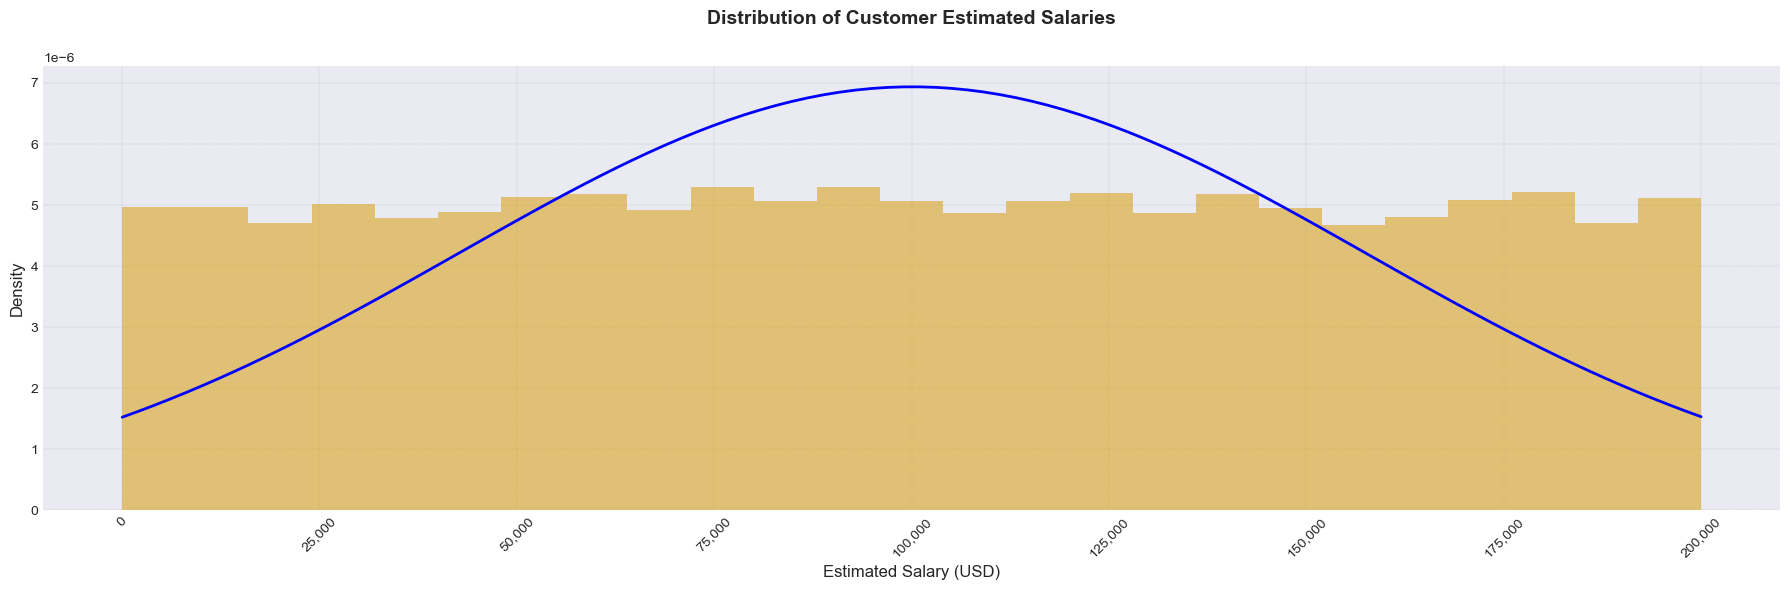

In [38]:
# Seting style for plot
plt.style.use('seaborn-v0_8-darkgrid')

# Creating figure and axis objects
fig, ax = plt.subplots(figsize=(18, 6))

# Creating histogram
data_modified.hist(column='EstimatedSalary', 
                   bins=25, 
                   color='goldenrod',
                   density=True,
                   alpha=0.6,
                   ax=ax
)

# Generating x-values for distribution curve
x = np.linspace(min(data_modified['EstimatedSalary']), max(data_modified['EstimatedSalary']), 100)

# Plotting distribution curve
ax.plot(x, stats.norm.pdf(x, 
                          np.mean(data_modified['EstimatedSalary']), 
                          np.std(data_modified['EstimatedSalary'])), 
        'b', 
        linewidth=2, 
        label='Normal Distribution'
)

# Customizing the plot
ax.set_title('Distribution of Customer Estimated Salaries', 
             pad=30, 
             fontsize=14, 
             fontweight='bold')
ax.set_xlabel('Estimated Salary (USD)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.grid(True, color='gray', linewidth=0.25, linestyle='--', alpha=0.5)

# Formatting x-axis labels with comma as thousand separator
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.tick_params(axis='x', rotation=45)

# Adjusting layout to prevent label cutoff
plt.tight_layout()

# Displaying the plot
plt.show()

In [39]:
# Displaying distribution from describe()

data_modified['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

<div style="border: 2px solid black; padding: 10px; margin: 10px">

For our Estimated Salary distribution we can definitely see a normal distribution across all salaries. This is helpful in knowing that the data is a good representation of the population of customers at Beta Bank.

</div>

#### Initiating Data Sets for ML

In [44]:
# Importing data, Encoding data, Splitting Data into Train & Validation Sets

# Original dataset imported above

# Splitting data Features & Target sets
target = data_modified['Exited']
features = data_modified.drop('Exited', axis=1)

# Using OHE to encode dataset after splitting
# drop_first=True parameter set to avoid duplicating values
features_ohe = pd.get_dummies(features, drop_first=True)

# Creating Training and Temporary sets to later create a final Test Set
# Temp set is set to 30% of original dataset (test_size=0.30)
# random_state=12345 to be able to replicate results
features_train, features_temp, target_train, target_temp = train_test_split(
    features_ohe, target, test_size=0.30, random_state=12345)

# Now creating Validation Set & Final Test Sets (15% split each)
# We're creating these sets from the "Temp" set
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.50, random_state=12345
)

<div style="border: 2px solid black; padding: 10px; margin: 10px">

First, we split the original dataset into two modified datasets to isolate the "target" and "feaures" data.

Then, we're utilizing One-Hot Encoding (OHE) to encode the non-numerical values within our "features" dataset. Ensuring we don't duplicate values by including 'drop_first=True'. 

Afterwards, we're creating the <b>training</b>, <b>validation</b>, and <b>test</b> datasets to train our model, later validate it's accuracy, and then a final test with unchanged and unique data. <br>
(Dataset distribution: Training = 70%, Validation = 15%, Test = 15%)

</div>

## Examining The Balance of Classes

#### Class Distribution

In [50]:
# Examining the balance of classes within our "target" dataset

# Displaying actual counts
print(target.value_counts())
print()

# Displaying percentages
print(target.value_counts(normalize=True))

Exited
0    7963
1    2037
Name: count, dtype: int64

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64


<div style="border: 2px solid black; padding: 10px; margin: 10px">

In our target, we have two classes present (0 and 1). We're seeing a steep imbalance of class in this original target dataset. The target is 'Exited', meaning 1 represents a "yes" and 0 represents a "no". Currently, roughly 20% of the customers in our data have exited, and almost 80% are still with the bank.

</div>

#### Training LogisticRegression Model with Imbalances

<div style="border: 2px solid black; padding: 10px; margin: 10px">

We will first train a model with the imbalanced classes to be able to compare later their variance once balanced.<br>

We'll calculate three scores to help us determine the models efficacy:<br> 
* <b>Precision</b> - the proportion of <u>True Positive</u> (TP) answers compared to the <u>TP</u> answers plus the <u>False Positive</u> (FP) answers. In other words, of all the answers the model deemed as positive, how many of those are actually <u>TP</u>'s?<br>

* <b>Recall</b> - the proportion of <u>TP</u> answers the model chose compared to those <u>TP</u>'s plus the <u>False Negative</u> (FN) answers depicted by the model. In other words, of all the possible <u>TP</u> answers, how many did the model accurately choose?<br>

* <b>F1 Score</b> - describes how well the model understood the properties of the target class and how well that class was recognized<br>

The closer these scores are to 1.0, the higher the model performance. 

</div>

In [56]:
# Training model without taking into account the imbalance

# Initiating LogisticRegression constructor with same random_state and solver='liblinear'
model = LogisticRegression(random_state=12345, solver='liblinear')

# Training model with training sets
model.fit(features_train, target_train)

# Predicting values using our Validation Set
predicted_valid = model.predict(features_valid)

# Calculating Scores
unbalanced_precision = precision_score(target_valid, predicted_valid)
unbalanced_recall = recall_score(target_valid, predicted_valid)
unbalanced_f1score = f1_score(target_valid, predicted_valid)

# Printing
print(f"Precision Score: {unbalanced_precision:.2f}")
print(f"Recall Score: {unbalanced_recall:.2f}")
print(f"F1 Score: {unbalanced_f1score:.2f}")

Precision Score: 0.57
Recall Score: 0.03
F1 Score: 0.05


<div style="border: 2px solid black; padding: 10px; margin: 10px">

Here's what the results are telling us:<br>

1. The <b>Precision</b> of our model is the highest of all three scores, meaning that the majority of the answers that the model is returning as "TP" are <u>actually</u> positive answers.<br><br>
2. Our <b>Recall</b> score is telling us that although the answers the model is choosing are often TP's, the model is still not choosing a vast majority of the possible TP's. This is an indication that our model is too strict, or trained too far in one direction, where it can't detect the majority of the answers we want it to find.<br><br>
3. Our overall score, as depicted by our <b>F1 Score</b> is low. It's telling us that the quality of the model is very low in predicting the positive class from our data.

</div>

#### Training DecisionTree Model with Imbalances

In [61]:
# Running through different tree depths to determine best fit

# Initiating variables
best_model_imb = None
best_result_imb = 0

# Creating "for" Loop
for depth in range(1, 11):
    
    # Creating model, asking it to loop through range in loop
    model_dt_imb = DecisionTreeClassifier(random_state=12345, max_depth=depth)

    # Training model to Unbalanced Data
    model_dt_imb.fit(features_train, target_train)

    # Evaluating results on Validation Set
    # Calculating F1 Score
    predictions_imb = model_dt_imb.predict(features_valid)
    result_imb = f1_score(target_valid, predictions_imb)

    # Setting evaluation metrics
    if result_imb > best_result_imb:
        best_model_imb = model_dt_imb
        best_result_imb = result_imb

print(f"Best Model: {best_model_imb}")
print()
print(f"F1 Score: {best_result_imb:.2f}")

Best Model: DecisionTreeClassifier(max_depth=5, random_state=12345)

F1 Score: 0.56


## Improving Model Quality

<div style="border: 2px solid black; padding: 10px; margin: 10px">

We need to improve our model's quality, to do this, we will implore the following techniques:<br>

* <b>Upsampling</b> - We'll upsample the Class "1" values to match the original Class "0" values
* <b>Downsampling</b> - We'll downsample the Class "0" values to match the original Class "1" values
* <b>Class Weight Adjustment</b> - Where we'll edit the weight the model places on each class<br>

Afterwards, we will then train different models to assess the best fit for the data.

</div>

### Fixing Class Imbalance

#### Upsampling the Model

In [70]:
# Checking shape of split data sets by class for reference
features_ups_zeros = features_train[target_train == 0]
features_ups_ones = features_train[target_train == 1]
target_ups_zeros = target_train[target_train == 0]
target_ups_ones = target_train[target_train == 1]

# Printing shapes
print(features_ups_zeros.shape)
print(features_ups_ones.shape)
print(target_ups_zeros.shape)
print(target_ups_ones.shape)

(5589, 11)
(1411, 11)
(5589,)
(1411,)


In [73]:
# Creating a function to split the classes, upsample the data
# shuffle the data, and return the new datasets

def upsample(features, target, repeat):
    # Splitting data by class
    features_ups_zeros = features[target == 0]
    features_ups_ones = features[target == 1]
    target_ups_zeros = target[target == 0]
    target_ups_ones = target[target == 1]

    # Upsampling data
    features_upsampled = pd.concat([features_ups_zeros] + [features_ups_ones] * repeat)
    target_upsampled = pd.concat([target_ups_zeros] + [target_ups_ones] * repeat)

    # Shuffling data
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


# Running function to upsample training set into
# "features_upsampled" and "target_upsampled"
# Using "3" because it produces a higher F1 Score
features_upsampled, target_upsampled = upsample(
    features_train, target_train, 3
)

#### Downsampling the Model

In [77]:
# Function similar to upsampling, using fraction instead of "repeat" variable

def downsample(features, target, fraction):
    # Splitting data by class
    features_ds_zeros = features[target == 0]
    features_ds_ones = features[target == 1]
    target_ds_zeros = target[target == 0]
    target_ds_ones = target[target == 1]

    # Downsampling data
    features_downsampled = pd.concat(
        [features_ds_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ds_ones]
    )
    
    target_downsampled = pd.concat(
        [target_ds_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ds_ones]
    )
    
    # Shuffling data
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled


# Running function to downsample training set into
# "features_downsampled" and "target_downsampled"
# Using 0.25 because minority class is about that percentage of majority class
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)

### Training Models | Upsampled Data

#### Logistic Regression
<i>Upsampled Data</i>

In [82]:
# Initiating LogisticRegression constructor with same random_state and solver='liblinear'
model_up = LogisticRegression(random_state=12345, solver='liblinear')

# Training model with upsampled sets
model_up.fit(features_upsampled, target_upsampled)

# Predicting values using our Validation Set
predicted_valid_up = model_up.predict(features_valid)

# Calculating F1 Score
upsampled_f1score = f1_score(target_valid, predicted_valid_up)

# Printing result
print(f"F1 Score: {upsampled_f1score:.2f}")

F1 Score: 0.45


#### Decision Tree
<i>Upsampled Data</i>

In [86]:
# Running through different tree depths to determine best fit

# Initiating variables
best_model_up = None
best_result_up = 0

# Creating "for" Loop
for depth in range(1, 11):
    
    # Creating model, asking it to loop through range in loop
    model_dt_up = DecisionTreeClassifier(random_state=12345, max_depth=depth)

    # Training model to Upsampled Data
    model_dt_up.fit(features_upsampled, target_upsampled)

    # Evaluating results on Validation Set
    # Calculating F1 Score
    predictions_up = model_dt_up.predict(features_valid)
    result_up = f1_score(target_valid, predictions_up)

    # Setting evaluation metrics
    if result_up > best_result_up:
        best_model_up = model_dt_up
        best_result_up = result_up

print(f"Best Model: {best_model_up}")
print()
print(f"F1 Score: {best_result_up:.2f}")

Best Model: DecisionTreeClassifier(max_depth=5, random_state=12345)

F1 Score: 0.61


#### Random Forest
<i>Upsampled Data</i>

In [90]:
# Running through different number of estimators

# Initializing variables
best_score_rf_up = 0
best_est_rf_up = 0

# Creating "for" Loop
for est in range(1, 11):

    # Creating model, asking it to loop through range in loop
    model_rf_up = RandomForestClassifier(random_state=12345, n_estimators=est)

    # Training model to Upsampled Data
    model_rf_up.fit(features_upsampled, target_upsampled)

    # Eval on Valid Set, Calculating Best Accuracy Score
    score_rf_up = model_rf_up.score(features_valid, target_valid)

    # Eval metrics
    if score_rf_up > best_score_rf_up:
        best_score_rf_up = score_rf_up # saving best accuracy score
        best_est_rf_up = est # saving number of estimators corresponding to best score

print("Accuracy of Best Model on Validation Set (n_estimators = {}): {:.2f}".format(best_est_rf_up, best_score_rf_up))
print()

# Initiating an instance of a random forest with the best number of estimators
final_model_rf_up = RandomForestClassifier(random_state=12345, n_estimators=best_est_rf_up)

# Training that model with the upsampled data
final_model_rf_up.fit(features_upsampled, target_upsampled)

# Calculating predictions on the final model with validation set
final_predictions_up = final_model_rf_up.predict(features_valid)

# Calculating F1 Score
final_f1score_up = f1_score(target_valid, final_predictions_up)

# Printing results
print(f"F1 Score: {final_f1score_up:.2f}")

Accuracy of Best Model on Validation Set (n_estimators = 10): 0.85

F1 Score: 0.57


### Training Models | Downsampled Data

#### Logistic Regression
<i>Downsampled Data</i>

In [95]:
# Initiating LogisticRegression constructor with same random_state and solver='liblinear'
model_down = LogisticRegression(random_state=12345, solver='liblinear')

# Training model with downsampled sets
model_down.fit(features_downsampled, target_downsampled)

# Predicting values using our Validation Set
predicted_valid_down = model_down.predict(features_valid)

# Calculating F1 Score
downsampled_f1score = f1_score(target_valid, predicted_valid_down)

# Printing result
print(f"F1 Score: {downsampled_f1score:.2f}")

F1 Score: 0.45


#### Decision Tree
<i>Downsampled Data</i>

In [99]:
# Running through different tree depths to determine best fit

# Initiating variables
best_model_down = None
best_result_down = 0

# Creating "for" Loop
for depth in range(1, 11):
    
    # Creating model, asking it to loop through range in loop
    model_dt_down = DecisionTreeClassifier(random_state=12345, max_depth=depth)

    # Training model to Downsampled Data
    model_dt_down.fit(features_downsampled, target_downsampled)

    # Evaluating results on Validation Set
    # Calculating F1 Score
    predictions_down = model_dt_down.predict(features_valid)
    result_down = f1_score(target_valid, predictions_down)

    # Setting evaluation metrics
    if result_down > best_result_down:
        best_model_down = model_dt_down
        best_result_down = result_down

print(f"Best Model: {best_model_down}")
print()
print(f"F1 Score: {best_result_down:.2f}")

Best Model: DecisionTreeClassifier(max_depth=5, random_state=12345)

F1 Score: 0.56


#### Random Forest
<i>Downsampled Data</i>

In [103]:
# Running through different number of estimators

# Initializing variables
best_score_rf_down = 0
best_est_rf_down = 0

# Creating "for" Loop
for est in range(1, 11):

    # Creating model, asking it to loop through range in loop
    model_rf_down = RandomForestClassifier(random_state=12345, n_estimators=est)

    # Training model to Downsampled Data
    model_rf_down.fit(features_downsampled, target_downsampled)

    # Eval on Valid Set, Calculating Best Accuracy Score
    score_rf_down = model_rf_down.score(features_valid, target_valid)

    # Eval metrics
    if score_rf_down > best_score_rf_down:
        best_score_rf_down = score_rf_down # saving best accuracy score
        best_est_rf_down = est # saving number of estimators corresponding to best score

print("Accuracy of Best Model on Validation Set (n_estimators = {}): {:.2f}".format(best_est_rf_down, best_score_rf_down))
print()

# Initiating an instance of a random forest with the best number of estimators
final_model_rf_down = RandomForestClassifier(random_state=12345, n_estimators=best_est_rf_down)

# Training that model with the upsampled data
final_model_rf_down.fit(features_downsampled, target_downsampled)

# Calculating predictions on the final model with validation set
final_predictions_down = final_model_rf_down.predict(features_valid)

# Calculating F1 Score
final_f1score_down = f1_score(target_valid, final_predictions_down)

# Printing results
print(f"F1 Score: {final_f1score_down:.2f}")


Accuracy of Best Model on Validation Set (n_estimators = 10): 0.79

F1 Score: 0.58


### Training Models | Balanced Classes

#### Logistic Regression
<i>Balanced Classes</i>

In [108]:
# Initiating LogisticRegression constructor with same random_state and solver='liblinear'
# Including "class_weight='balanced'" to balance classes
model_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

# Training model with training sets
model_balanced.fit(features_train, target_train)

# Predicting values using our Validation Set
predicted_balanced = model_balanced.predict(features_valid)

# Calculating F1 Score
balanced_f1score = f1_score(target_valid, predicted_balanced)

# Printing result
print(f"F1 Score: {balanced_f1score:.2f}")

F1 Score: 0.48


#### Decision Tree
<i>Balanced Classes</i>

In [112]:
# Running through different tree depths to determine best fit

# Initiating variables
best_model_balanced = None
best_result_balanced = 0

# Creating "for" Loop
for depth in range(1, 11):
    
    # Creating model, asking it to loop through range in loop
    model_dt_balanced = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')

    # Training model to Balanced Data
    model_dt_balanced.fit(features_train, target_train)

    # Evaluating results on Validation Set
    # Calculating F1 Score
    predictions_dt_balanced = model_dt_balanced.predict(features_valid)
    result_dt_balanced = f1_score(target_valid, predictions_dt_balanced)

    # Setting evaluation metrics
    if result_dt_balanced > best_result_balanced:
        best_model_balanced = model_dt_balanced
        best_result_balanced = result_dt_balanced

print(f"Best Model: {best_model_balanced}")
print()
print(f"F1 Score: {best_result_balanced:.2f}")

Best Model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)

F1 Score: 0.60


#### Random Forest
<i>Balanced Classes</i>

In [116]:
# Running through different number of estimators

# Initializing variables
best_score_rf_balanced = 0
best_est_rf_balanced = 0

# Creating "for" Loop
for est in range(1, 11):

    # Creating model, asking it to loop through range in loop
    model_rf_balanced = RandomForestClassifier(random_state=12345, n_estimators=est, class_weight='balanced')

    # Training model to Balanced Data
    model_rf_balanced.fit(features_train, target_train)

    # Eval on Valid Set, Calculating Best Accuracy Score
    score_rf_balanced = model_rf_balanced.score(features_valid, target_valid)

    # Eval metrics
    if score_rf_balanced > best_score_rf_balanced:
        best_score_rf_balanced = score_rf_balanced # saving best accuracy score
        best_est_rf_balanced = est # saving number of estimators corresponding to best score

print("Accuracy of Best Model on Validation Set (n_estimators = {}): {:.2f}".format(best_est_rf_balanced, best_score_rf_balanced))
print()

# Initiating an instance of a random forest with the best number of estimators
final_model_rf_balanced = RandomForestClassifier(random_state=12345, n_estimators=best_est_rf_balanced)

# Training that model with the upsampled data
final_model_rf_balanced.fit(features_train, target_train)

# Calculating predictions on the final model with validation set
final_predictions_balanced = final_model_rf_balanced.predict(features_valid)

# Calculating F1 Score
final_f1score_balanced = f1_score(target_valid, final_predictions_balanced)

# Printing results
print(f"F1 Score: {final_f1score_balanced:.2f}")


Accuracy of Best Model on Validation Set (n_estimators = 9): 0.85

F1 Score: 0.59


### Model Quality Improvement Conclusions

<div style="border: 2px solid black; padding: 10px; margin: 10px">

As we look through our iterations between Logistic Regression, Decision Tree and Random Forest models using our upsampled, downsampled and class-balanced datasets, we see there is a clear winner whose <u>F1 Score reached 0.61</u>. The <b>RandomForest</b> model using our <b>Upsampled</b> datasets proved to be the best model in this business challenge.<br>

The <u>LogicisticRegression</u> model was the <b>worst performing</b> model for all three methods of improving model quality.<br>

Below we will conduct a final test on the "test" dataset created at the beginning of this project to determine reproducibility. We will also measure the AUC-ROC metric and compare it with the F1 of this final test.

</div>

## Final Testing
<i>RandomForest</i>

In [124]:
# Running Final "Test" on RandomForest Model with best parameters from above
# Using the "upsampled" data to train the model and "test" data to validate it
# Number of estimators = 8 (best in model tested against validation set)

# Initiating an instance of a random forest with the best number of estimators
model_test = RandomForestClassifier(random_state=12345, n_estimators=8)

# Training that model with the upsampled data
model_test.fit(features_upsampled, target_upsampled)

# Calculating predictions on the final model with test set
predictions_test = model_test.predict(features_test)

# Calculating F1 Score
f1score_test = f1_score(target_test, predictions_test)

# Printing results
print(f"RandomForest F1 Score: {f1score_test:.2f}")

RandomForest F1 Score: 0.52


<div style="border: 2px solid black; padding: 10px; margin: 10px">

Although this model proved to be the highest performing in terms of the F1 Score during our analysis, it's showing a much lower score after validating a model trained with the upsampled data compated to our "test" datasets.<br>

We will attempt to train a model using the <b>DecisionTreeClassifier</b> which was the second best score (0.60) after the RandomForest.

</div>

In [128]:
# Final Test using DecisionTree instead of RandomForest

# Initiating an instance of a DecisionTree with the best max depth from above
model_test2 = DecisionTreeClassifier(random_state=12345, max_depth=5)

# Training that model with the upsampled data
model_test2.fit(features_upsampled, target_upsampled)

# Calculating predictions on the final model with test set
predictions_test2 = model_test2.predict(features_test)

# Calculating F1 Score
f1score_test2 = f1_score(target_test, predictions_test2)

# Printing results
print(f"DecisionTree F1 Score: {f1score_test2:.2f}")

DecisionTree F1 Score: 0.60


<div style="border: 2px solid black; padding: 10px; margin: 10px">

This is the result we were looking for!<br>

It turns out that the <b>DecisionTree</b> model is the best for the <b>validation</b> set <u>and</u> the <b>test</b> set. This model is more reliable and better suited than the RandomForest. 

</div>

### Comparing F1 Score to AUC-ROC Metric

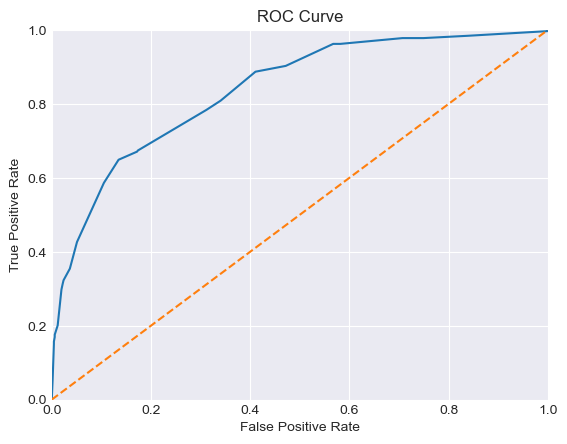

In [133]:
# Using the model from the final test to calculate AUC-ROC metric

# Creating probabilities
probabilities_test = model_test2.predict_proba(features_test)

# Separating positive predictions from probabilities
probabilities_one_test = probabilities_test[:, 1]

# Creating the ROC curve
# target_test dataset & probabilities of positive observations
fpt, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

# Initiating figure
plt.figure()

# Plotting FPR & TPR
plt.plot(fpt, tpr)

# ROC for random model (straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# Setting boundaries for axes, 0 to 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Labeling the axes
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Heading
plt.title("ROC Curve")

# Showing figure
plt.show()

In [136]:
# Calculating AUC-ROC Score
auc_roc = roc_auc_score(target_test, probabilities_one_test)

# Printing Final F1 Scoreo & AUC-ROC Score for Comparison
print(f"Final F1 Score: {f1score_test2:.2f}")
print(f"AUC-ROC Score: {auc_roc:.2f}")

Final F1 Score: 0.60
AUC-ROC Score: 0.84


<div style="border: 2px solid black; padding: 10px; margin: 10px">

Based on our <b>AUC-ROC Score</b>, we're seeing a high performance score of the model compared to a random classifier.<br>

Our <b>F1 Score</b> is indicating a good balance between Precision and Recall for the model.

</div>

## Final Conclusions

<div style="border: 2px solid black; padding: 10px; margin: 10px">

We were successful in building a model that beat the goal of an <u>F1 Score</u> of <b>0.59</b> and produced an <u>AUC-ROC Score</u> of <b>0.84</b>.<br>

This shows that the model we've build can be used to assist Beta Bank in determing which of their customers are at risk for leaving the company. This will ultimately aid in identifying which customers may actually leave the company and systems can be developed and implemented for retaining those customers. More data may be beneficial in gaining a higher F1 Score or AUC-ROC score, but this is a good starting point for the company to prevent their customers from going to other banking companies. 

</div>